  0.000273 seconds (331 allocations: 26.969 KiB)


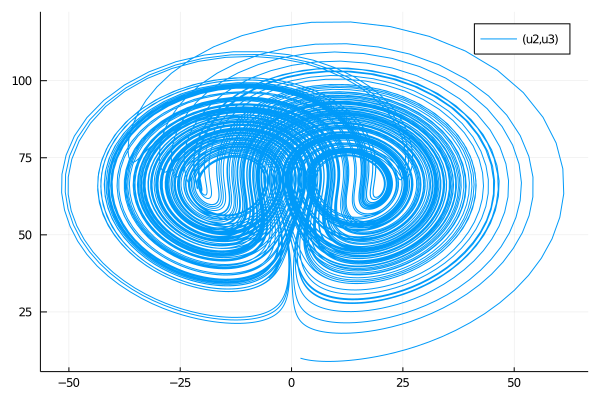

In [3]:
using DifferentialEquations
using Plots

function lorenz!(du,u,p,t)
 du[1] = 10.0*(u[2]-u[1])
 du[2] = u[1]*(68.0-u[3]) - u[2]
 du[3] = u[1]*u[2] - (8/3)*u[3]
end

u0 = [1.0;2.0;10.0]
tspan = (0.0,100.0)
@time prob = ODEProblem(lorenz!,u0,tspan)
sol = solve(prob)

plot(sol,vars=(2,3))

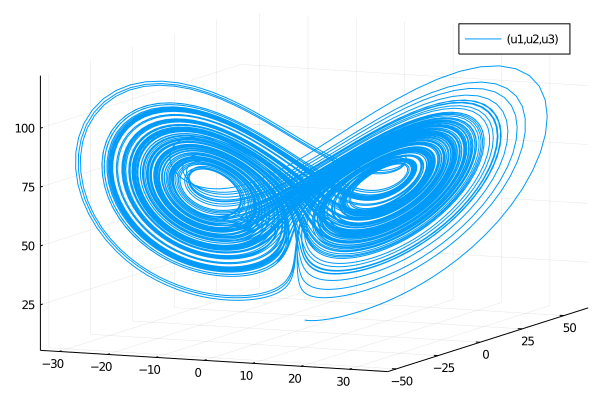

In [4]:
plot(sol,vars=(1,2,3))